#### Import libraries and the activark script (prepareTestData)

In [11]:
import prepareTestData as activark
import numpy as np
from sklearn.metrics import accuracy_score, matthews_corrcoef, roc_auc_score

#### Create a class to store mutation information

In [2]:
class Mutation:
    def __init__(self, mutation, mutationType):
        self.mutation = mutation
        self.mutationType = [mutationType]
        self.results = None

#### Specificy the input file (assuming the first col is in mechismo-like format)

In [3]:
INPUT_FILE = 'final_ADRN.txt'

#### Read the input file and store information in a dic using the class defined above as template. Save the extracted mutations in a new file called input.txt, which will used to give as input to activark as input in the next step.

In [4]:
dic_mutations = {}
for line in open(INPUT_FILE, 'r'):
    mutation, mutationType = line.strip().split('\t')
    if mutation not in dic_mutations:
        dic_mutations[mutation] = Mutation(mutation, mutationType)
    else:
        if mutationType not in dic_mutations[mutation].mutationType:
            dic_mutations[mutation].mutationType.append(mutationType)

l = ''
for mutation in dic_mutations:
    # if 'Activating' in dic_mutations[mutation].mutationType:
        l += mutation + '\n'
open('input.txt', 'w').write(l)
print (len(l.split('\n')[:-1]))

223


#### Run activark to make predictions
The results return a JSON object with 3 keys:
1. predictions: mutation-wise predictions
2. overEntries: number of entries(mutations) that were ignored (by defualt first 100 mutations are consdered)
3. entries_not_found: entries (mutations) that were ignored because they were not found in the database.

In [ ]:
results = activark.predict(5, 'input.txt')
print(results.keys())

In [32]:
# copy results by value
result_xgb = results
results_rf = activark.predict(5, 'input.txt', algo='RF')

100%|██████████| 224/224 [10:57<00:00,  2.94s/it]


--------------------------------------------------------------------------------
# Activark predictions
# 01/04/2024 13:55:01
# Input: input.txt
    UserInput UniProtAcc GeneName   UniProtID Mutation HMMpos                   Region PTM KnownADR  NeighSites     N     D     A   RvN AIvLD AIvNLD LDvNAI  AIvN  LDvN
 O60674/H608N     O60674     JAK2  JAK2_HUMAN    H608N    173               αC/β4-loop   -        - KLSHKhVLNYG 0.244 0.262 0.494 0.467 0.647  0.509  0.382 0.587 0.466
 O60674/H608Y     O60674     JAK2  JAK2_HUMAN    H608Y    173               αC/β4-loop   -        - KLSHKhVLNYG 0.333 0.223 0.444 0.344 0.656  0.532  0.325 0.499 0.369
 O60674/L604F     O60674     JAK2  JAK2_HUMAN    L604F    159               αC/β4-loop   -        - SMMSKlHKHLV 0.492 0.183 0.325  0.47 0.617  0.507  0.344 0.382 0.298
 O96013/I417T     O96013     PAK4  PAK4_HUMAN    I417T    371                       αE   -        - MNEEQiAVCLA 0.175 0.435 0.391 0.531 0.501  0.477   0.53 0.534 0.623
 P00533/R776L  

In [54]:
# calculate metrics of the AIvLD model
def metrics(positive, negative, model_name):
    results = results_rf
    y_true = []
    y_pred_prob = []
    y_pred_label = []
    for mutation in results['predictions']:
        if positive not in dic_mutations[mutation].mutationType and negative not in dic_mutations[mutation].mutationType:
            continue
        pred = results['predictions'][mutation][model_name]
        if pred.split() == ['NA']:
            continue
        # print (mutation, pred)
        y_pred_prob.append(float(pred))
        y_pred_label.append(1 if float(pred) > 0.5 else 0)
        y_true.append(1 if positive in dic_mutations[mutation].mutationType else 0)
    accuracy = accuracy_score(y_true, y_pred_label)
    print (f'{positive[0]}vs{negative[0]} using {model_name} has ACC of {round(accuracy, 3)}')
    print (f'{positive[0]}vs{negative[0]} using {model_name} has MCC of {round(matthews_corrcoef(y_true, y_pred_label), 3)}')
    print (f'{positive[0]}vs{negative[0]} using {model_name} has AUC of {round(roc_auc_score(y_true, y_pred_prob), 3)}')

In [55]:
# calculate metrics of the AIvLD model

metrics('Activating', 'Deactivating', 'AIvLD')
metrics('Resistance', 'Neutral', 'RvN')

AvsD using AIvLD has ACC of 0.89
AvsD using AIvLD has MCC of 0.792
AvsD using AIvLD has AUC of 0.911
RvsN using RvN has ACC of 0.81
RvsN using RvN has MCC of 0.562
RvsN using RvN has AUC of 0.865


AvsD using AIvLD/XGB has ACC of 0.829
AvsD using AIvLD/XGB has MCC of 0.662
AvsD using AIvLD/XGB has AUC of 0.907
RvsN using RvN/XGB has ACC of 0.778
RvsN using RvN/XGB has MCC of 0.473
RvsN using RvN/XGB has AUC of 0.865
AvsD using AIvLD/RF has ACC of 0.89
AvsD using AIvLD/RF has MCC of 0.792
AvsD using AIvLD/RF has AUC of 0.911
RvsN using RvN/RF has ACC of 0.81
RvsN using RvN/RF has MCC of 0.562
RvsN using RvN/RF has AUC of 0.865
Algo	Model	ACC	MCC	AUC
XGB	AIvLD	0.829	0.662	0.907
XGB	RvN	0.778	0.473	0.865
RF	AIvLD	0.89	0.792	0.911
RF	RvN	0.81	0.562	0.865


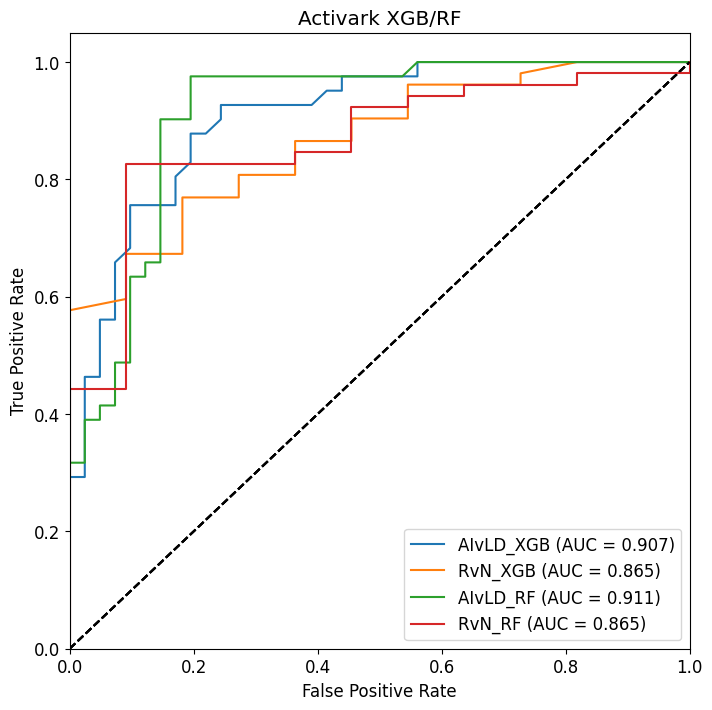

In [65]:
# Plot ROC curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import matplotlib as mpl
mpl.rcParams['font.size'] = 12

def plot_roc():
    data = []
    for algo, results in [('XGB', result_xgb), ('RF', results_rf)]:
        for positive, negative, model_name in [('Activating', 'Deactivating', 'AIvLD'), ('Resistance', 'Neutral', 'RvN')]:
            y_true = []
            y_pred_prob = []
            y_pred_label = []
            for mutation in results['predictions']:
                if positive not in dic_mutations[mutation].mutationType and negative not in dic_mutations[mutation].mutationType:
                    continue
                pred = results['predictions'][mutation][model_name]
                if pred.split() == ['NA']:
                    continue
                y_pred_prob.append(float(pred))
                y_pred_label.append(1 if float(pred) > 0.5 else 0)
                y_true.append(1 if positive in dic_mutations[mutation].mutationType else 0)
            # print metrics
            acc = round(accuracy_score(y_true, y_pred_label),3)
            mcc = round(matthews_corrcoef(y_true, y_pred_label),3)
            auc_score = round(roc_auc_score(y_true, y_pred_prob),3)
            print (f'{positive[0]}vs{negative[0]} using {model_name}/{algo} has ACC of {round(acc, 3)}')
            print (f'{positive[0]}vs{negative[0]} using {model_name}/{algo} has MCC of {round(mcc, 3)}')
            print (f'{positive[0]}vs{negative[0]} using {model_name}/{algo} has AUC of {round(auc_score, 3)}')
            data.append([algo, model_name, acc, mcc, auc_score])
            # plot ROC curve
            fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
            roc_auc = auc(fpr, tpr)
            label_name = f'{model_name}_{algo} (AUC = {round(roc_auc, 3)})'
            plt.plot(fpr, tpr, label=label_name)
            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.legend(loc="lower right")
            plt.title(f'Activark XGB/RF')
    # print metrics
    print ('\t'.join(['Algo', 'Model', 'ACC', 'MCC', 'AUC']))
    # print (data)
    for d in data:
        print ('\t'.join(map(str, d)))

plt.figure(figsize=(8, 8))
plot_roc()
plt.grid()
plt.savefig('roc_curve_XGB_RF.png', dpi=1000)